In [53]:
#load the modules
import keras
from keras import models, layers
from keras.activations import relu, softmax
from tensorflow.keras.applications import VGG19
from keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Dense, Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.metrics import TopKCategoricalAccuracy
sys.modules['Image'] = Image

In [32]:
# Keras' data generator can be used to pass the images through the convolutional neural network and apply
#rotation and zoom transformations to the images. Check https://keras.io/preprocessing/image/ for more transformations

train_data = ImageDataGenerator(
        rotation_range=40,
        zoom_range=0.2,
        rescale = 1./255)

train_generator = train_data.flow_from_directory(
        directory=r"../sorted_images/train",
        target_size=(224, 224),
        batch_size=5,
        shuffle=True)

Found 1835 images belonging to 100 classes.


In [31]:
#defining the validation data generator
val_data = ImageDataGenerator(rescale = 1./255)
                                 
val_generator = val_data.flow_from_directory(
        directory=r"../sorted_images/val",
        target_size=(224, 224),
        batch_size=5,
        shuffle=True)

Found 303 images belonging to 100 classes.


## Convolutional neural network

In [19]:
#load the pre-trained VGG19 from keras
vgg19 = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = vgg19.layers[-1].output
#add dropout and the fully connected layer
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
#add a dense layer with a value equal to the number of classes
predictors = Dense(100, activation='softmax')(x)
# Create the model
vgg19model = Model(vgg19.input, predictors)

In [20]:
#check the model
vgg19model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [21]:
# define where to save the model after each epoch
filepath = "../models/Saved_model.h5"
# add a critera to save only if there was an improvement in the model comparing
# to the previous epoch (in this caset the model is saved if there was a decrease in the loss value)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# stop training if there is no improvement in model for 3 consecutives epochs.
early_stopping_monitor = EarlyStopping(patience=3)
callbacks_list = [checkpoint, early_stopping_monitor]

In [29]:
# Compile the model
vgg19model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5),#define the optimizer and the learning rate
              metrics=tf.keras.metrics.TopKCategoricalAccuracy(k=5))

In [34]:
#train the model
batch_size=5
model_history=vgg19model.fit_generator(
        train_generator,
        steps_per_epoch=1835//batch_size,#number of pictures in training data set divided by the batch size
        epochs=30,
        validation_data=val_generator,
        validation_steps= 300// batch_size,#number of pictures in validation data set divided by the batch size
        callbacks=callbacks_list)

/var/folders/jl/yr_857sx3mz_26fn6qdhy_w40000gn/T/ipykernel_2421/2782455145.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history=vgg19model.fit_generator(


Epoch 1/30
367/367 [==============================] - ETA: 0s - loss: 4.4675 - top_k_categorical_accuracy: 0.1553
Epoch 00001: val_loss improved from inf to 4.75889, saving model to ../models/Saved_model.h5
367/367 [==============================] - 178s 485ms/step - loss: 4.4675 - top_k_categorical_accuracy: 0.1553 - val_loss: 4.7589 - val_top_k_categorical_accuracy: 0.0567
Epoch 2/30
367/367 [==============================] - ETA: 0s - loss: 4.4437 - top_k_categorical_accuracy: 0.1651
Epoch 00002: val_loss improved from 4.75889 to 4.72892, saving model to ../models/Saved_model.h5
367/367 [==============================] - 192s 523ms/step - loss: 4.4437 - top_k_categorical_accuracy: 0.1651 - val_loss: 4.7289 - val_top_k_categorical_accuracy: 0.0733
Epoch 3/30
367/367 [==============================] - ETA: 0s - loss: 4.3780 - top_k_categorical_accuracy: 0.1842
Epoch 00003: val_loss improved from 4.72892 to 4.66581, saving model to ../models/Saved_model.h5
367/367 [====================

In [36]:
#load the model
model=load_model("../models/Saved_model.h5")

# Compile the model
model.compile(loss='categorical_crossentropy',
             optimizer=SGD(lr=1e-6),
             metrics=tf.keras.metrics.TopKCategoricalAccuracy(k=5))
#train the model
batch_size=5
model_history_2=model.fit_generator(
        train_generator,
        steps_per_epoch=1835//batch_size,
        epochs=30,
        validation_data=val_generator,
        validation_steps= 300// batch_size,
        callbacks=callbacks_list)

/Users/tobiasengbring/neuefische/Capstone_Project_Turtle_Recall/.venv/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/var/folders/jl/yr_857sx3mz_26fn6qdhy_w40000gn/T/ipykernel_2421/830658345.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history_2=model.fit_generator(


Epoch 1/30
367/367 [==============================] - ETA: 0s - loss: 2.6699 - top_k_categorical_accuracy: 0.6300
Epoch 00001: val_loss improved from 4.06994 to 4.05205, saving model to ../models/Saved_model.h5
367/367 [==============================] - 201s 546ms/step - loss: 2.6699 - top_k_categorical_accuracy: 0.6300 - val_loss: 4.0521 - val_top_k_categorical_accuracy: 0.3167
Epoch 2/30
367/367 [==============================] - ETA: 0s - loss: 2.5552 - top_k_categorical_accuracy: 0.6561
Epoch 00002: val_loss improved from 4.05205 to 4.03636, saving model to ../models/Saved_model.h5
367/367 [==============================] - 233s 634ms/step - loss: 2.5552 - top_k_categorical_accuracy: 0.6561 - val_loss: 4.0364 - val_top_k_categorical_accuracy: 0.3367
Epoch 3/30
367/367 [==============================] - ETA: 0s - loss: 2.5329 - top_k_categorical_accuracy: 0.6550
Epoch 00003: val_loss did not improve from 4.03636
367/367 [==============================] - 231s 629ms/step - loss: 2.53

KeyError: <keras.metrics.TopKCategoricalAccuracy object at 0x2bb616220>

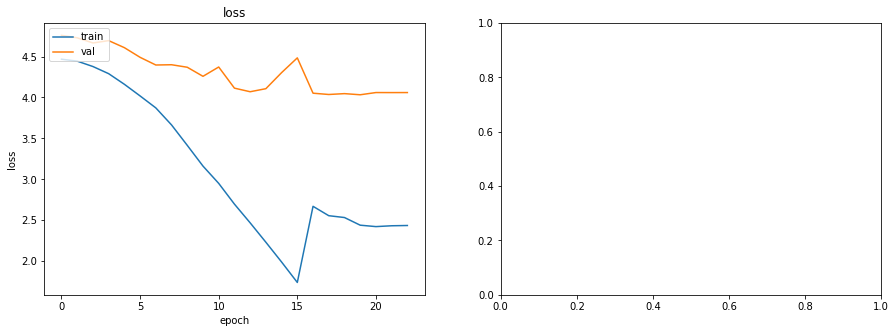

In [37]:
#size of the plots
fig=plt.figure(figsize=(15,5))
columns = 2
rows = 1

#plot loss
#the accuracy and loss are stored in the "model_history"
fig.add_subplot(rows, columns, 1)
plt.plot(model_history.history['loss']+ model_history_2.history['loss']) #merge the loss from the two training steps
plt.plot(model_history.history['val_loss']+ model_history_2.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

#plot accuracy
fig.add_subplot(rows, columns, 2)
plt.plot(model_history.history['acc']+ model_history_2.history['acc'])
plt.plot(model_history.history['val_acc']+ model_history_2.history['val_acc'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


### Testing the model + submission

Prepare the data for submission

In [ ]:
#load the best saved trained model
model=load_model("../models/Saved_model.h5")

In [213]:
val_sony_datagen1 = ImageDataGenerator(rescale = 1./255)
val_sony_datagen = val_sony_datagen1.flow_from_directory(
        directory=r"../sorted_images/test", #This folder should contain pictures of each bird in a different subfolder (similar to the training data set)
        target_size=(224, 224),
        batch_size=490, #number of images in the testing dataset
        shuffle=False)

Found 490 images belonging to 491 classes.


In [214]:
#load the pictures in the testing folder. The x_batch contains the pictures and the y_batch contains the
#identities of the individuals
x_batch, y_batch=next(val_sony_datagen)

In [215]:
predictions_index = []

#for i in range(0,len(x_batch)):
for i in range(0,len(x_batch)):    
    index_sorted = [] 
    image=np.expand_dims(x_batch[i], axis=0)
    result=model.predict(image)
    y_preds_indices = np.argsort(result)[:,-5:]

    for index in range(1,6):
        index_sorted.append(y_preds_indices[0][-index])
    predictions_index.append(index_sorted)
    

In [216]:
train_data = pd.read_csv('../data/train_corrected.csv')
unique_turtle_ids = list(train_data['turtle_id'].unique())

TypeError: 'list' object is not callable

In [201]:
list = []
array = []
for line in predictions_index:
    for id in line:
        list.append(unique_turtle_ids[id])
    array.append(list)
    list = []

TypeError: 'numpy.int64' object is not iterable

In [203]:
titles = ['prediction1', 'prediction2','prediction3','prediction4','prediction5']
submission = pd.DataFrame(array, columns= titles)

#Insert image_ids from test_data
test_data = pd.read_csv('../data/test.csv')
submission.insert(loc=0, column='image_id', value=test_data['image_id'])
submission

,image_id,prediction1,prediction2,prediction3,prediction4,prediction5
0,ID_6NEDKOYZ,t_id_3K93fQBS,t_id_2QmcRkNj,t_id_7gFFZy7i,t_id_dc6pjonY,t_id_gGQbn7FA
1,ID_57QZ4S9N,t_id_smNwfXAT,t_id_B7LaSiac,t_id_VFb44eFm,t_id_stWei2Uq,t_id_BI99coHt
2,ID_OCGGJS5X,t_id_VP2NW7aV,t_id_Kc1tXDbJ,t_id_dc6pjonY,t_id_pCO59rOk,t_id_uMOOrQu7
3,ID_R2993S3S,t_id_tjWepji1,t_id_MwnEYfqe,t_id_GOIvCduN,t_id_hibDzPAP,t_id_87CLFCvE
4,ID_2E011NB0,t_id_fxTQ5vHC,t_id_uMOOrQu7,t_id_BI99coHt,t_id_p77GDtzg,t_id_dc6pjonY
...,...,...,...,...,...,...
485,ID_0RVNUKK1,t_id_FBsGDJhU,t_id_Kc1tXDbJ,t_id_n2FBHk6d,t_id_D7NA71la,t_id_WDCMGvI4
486,ID_6405IKG3,t_id_GrxmyS59,t_id_p77GDtzg,t_id_pCO59rOk,t_id_k1rScFLB,t_id_smNwfXAT
487,ID_6WVPVB7S,t_id_4ZfTUmwL,t_id_MwnEYfqe,t_id_UVQa4BMz,t_id_utw0thCe,t_id_e9i3Lbq4
488,ID_47C5LL2G,t_id_Kc1tXDbJ,t_id_VFb44eFm,t_id_4ZfTUmwL,t_id_WDCMGvI4,t_id_G5JLzvai


In [206]:
#Save submission data as CSV
submission.to_csv('../data/submission_new_pipeline.csv', index = False)